In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt 
import os
import cv2
from patchify import patchify
from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import pandas as pd

## Data Preparation

### Loading Data 

In [2]:
root_directory = "Semantic segmentation dataset"
patch_size = 256
scaler = MinMaxScaler()

image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname= path.split(os.path.sep)[-1]
    if dirname == "images":
        images = os.listdir(path)
     #   print(images)
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):
                image = cv2.imread(path+os.path.sep+image_name,cv2.IMREAD_COLOR)
                image_before_crop = image
                image_before_crop = Image.fromarray(image_before_crop)
                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image_after_crop = image.crop((0,0,SIZE_X,SIZE_Y))
                image = np.array(image_after_crop)

                #Extract patches from each image
                print("Now patchifying image: ",path,"/",image_name)
                patches_img = patchify(image, (patch_size,patch_size,3),step=256)

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i,j,:,:].squeeze()
                        #print(single_patch_img.shape[-1])
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        image_dataset.append(single_patch_img)

Now patchifying image:  Semantic segmentation dataset\Tile 1\images / image_part_001.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 1\images / image_part_002.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 1\images / image_part_003.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 1\images / image_part_004.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 1\images / image_part_005.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 1\images / image_part_006.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 1\images / image_part_007.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 1\images / image_part_008.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 1\images / image_part_009.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 2\images / image_part_001.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 2\images / image_part_002.jpg
Now patchifying image

Mask Dataset

In [3]:
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:].squeeze()

                        mask_dataset.append(single_patch_mask) 

Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_001.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_002.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_003.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_004.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_005.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_006.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_007.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_008.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_009.png
Now patchifying mask: Semantic segmentation dataset\Tile 2\masks/image_part_001.png
Now patchifying mask: Semantic segmentation dataset\Tile 2\masks/image_part_002.png
Now patchifying mask: Semantic segmentation dataset\Tile 2\masks/image_part_

In [4]:
import torch.utils.data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision

In [5]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
image_dataset = torch.from_numpy(image_dataset)


In [6]:
mask_dataset.shape, image_dataset.shape

((1305, 256, 256, 3), torch.Size([1305, 256, 256, 3]))

In [7]:
mask_dataset.dtype,image_dataset.dtype

(dtype('uint8'), torch.float64)

## Image And Mask Saved in Files

In [193]:
import torch
import torchvision
from pathlib import Path

# Örnek image dataset (örnek olarak random tensörler oluşturulmuştur)
# Sizin datasetiniz bu şekildedir diye varsayıyorum.
# Eğer numpy array ise `torch.tensor` kullanarak tensöre dönüştürmelisiniz.
# image_dataset = ...

# Şekli [1305, 256, 256, 3] olan dataset
# Klasör oluşturma
FOLDER_PATH = Path("ImageDataset")
FOLDER_PATH.mkdir(parents=True, exist_ok=True)

# Görüntüleri kaydetme
for i in range(image_dataset.shape[0]):
    FILE_NAME = Path(f"image_{i}.jpg")
    FILE_PATH = FOLDER_PATH / FILE_NAME  # Path nesnelerini birleştiriyoruz
    
    # [H, W, C] -> [C, H, W] formatına permute etme
    image = image_dataset[i].permute(2, 0, 1)
    # Görüntüyü kaydetme
    torchvision.utils.save_image(image, FILE_PATH)

print(f"Images saved in {FOLDER_PATH}")


Images saved in ImageDataset


In [9]:
image.shape

torch.Size([3, 256, 256])

In [10]:
import torch
import torchvision
from pathlib import Path

# Örnek image dataset (örnek olarak random tensörler oluşturulmuştur)
# Sizin datasetiniz bu şekildedir diye varsayıyorum.
# Eğer numpy array ise `torch.tensor` kullanarak tensöre dönüştürmelisiniz.
# image_dataset = ...

# Şekli [1305, 256, 256, 3] olan dataset
# Klasör oluşturma
FOLDER_PATH = Path("MaskDataset")
FOLDER_PATH.mkdir(parents=True, exist_ok=True)

# Görüntüleri kaydetme
for i in range(mask_dataset.shape[0]):
    FILE_NAME = Path(f"image_{i}.png")
    FILE_PATH = FOLDER_PATH / FILE_NAME  # Path nesnelerini birleştiriyoruz
    
    # [H, W, C] -> [C, H, W] formatına permute etme
    mask = mask_dataset[i]
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)

    print(FILE_PATH)
    # Görüntüyü kaydetme
    cv2.imwrite(filename=FILE_PATH,img=mask)

print(f"Maskes saved in {FOLDER_PATH}")


MaskDataset\image_0.png
MaskDataset\image_1.png
MaskDataset\image_2.png
MaskDataset\image_3.png
MaskDataset\image_4.png
MaskDataset\image_5.png
MaskDataset\image_6.png
MaskDataset\image_7.png
MaskDataset\image_8.png
MaskDataset\image_9.png
MaskDataset\image_10.png
MaskDataset\image_11.png
MaskDataset\image_12.png
MaskDataset\image_13.png
MaskDataset\image_14.png
MaskDataset\image_15.png
MaskDataset\image_16.png
MaskDataset\image_17.png
MaskDataset\image_18.png
MaskDataset\image_19.png
MaskDataset\image_20.png
MaskDataset\image_21.png
MaskDataset\image_22.png
MaskDataset\image_23.png
MaskDataset\image_24.png
MaskDataset\image_25.png
MaskDataset\image_26.png
MaskDataset\image_27.png
MaskDataset\image_28.png
MaskDataset\image_29.png
MaskDataset\image_30.png
MaskDataset\image_31.png
MaskDataset\image_32.png
MaskDataset\image_33.png
MaskDataset\image_34.png
MaskDataset\image_35.png
MaskDataset\image_36.png
MaskDataset\image_37.png
MaskDataset\image_38.png
MaskDataset\image_39.png
MaskDatase

In [11]:
mask_dataset.shape,mask.shape,type(mask)

((1305, 256, 256, 3), (256, 256, 3), numpy.ndarray)

In [12]:
#IOU

In [13]:
image_dataset.shape

torch.Size([1305, 256, 256, 3])

Image Generation for Chechk

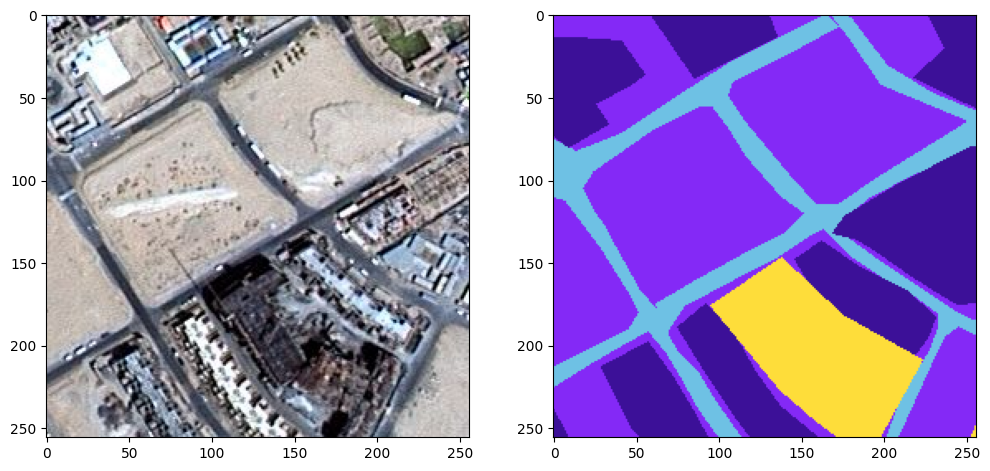

In [14]:
import random
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
print()
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

Pathcing

(256, 256, 3)

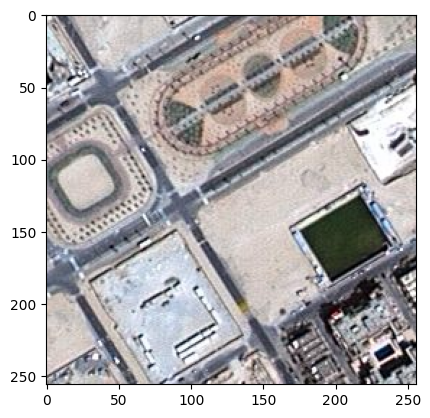

In [15]:
patches_img
plt.imshow(patches_img[2,1].squeeze())
patches_img[2,1].squeeze().shape

Crop

Text(0.5, 1.0, 'Image After Crop')

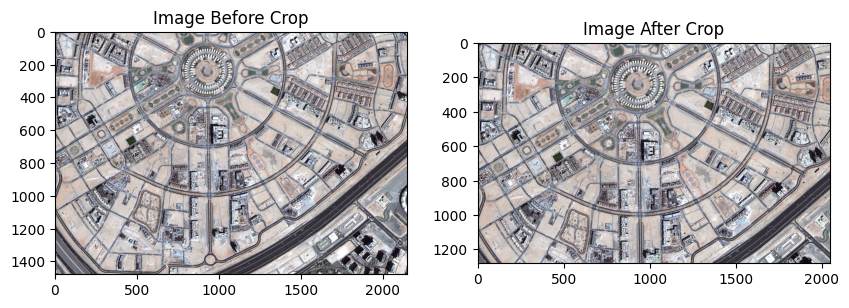

In [16]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(image_before_crop)
plt.title("Image Before Crop")
plt.subplot(1,2,2)
plt.imshow(image_after_crop)
plt.title("Image After Crop")

### Calculating RGB from HEX: #3C1098

    R = 201/16 = 12 with remainder of 9. So hex dode for R is C9 (remember C=12)

    3C = 3*16 + 12 = 60
    10 = 1*16 + 0 = 16
    90 = 9*16 + 8 = 152


    Building: #3C1098
    Land (unpaved area): #8429F6
    Road: #6EC1E4
    Vegetation: #FEDD3A
    Water: #E2A929
    Unlabeled: #9B9B9B

In [17]:
a = int("3C",16) #3C with base 15. Should return 60.
a

60

In [18]:
Building = "#3C1098".lstrip("#")
temp_list = []
for i in (0,2,4):
    temp_list.append(int(Building[i:i+2],16))
Building = np.array(temp_list)
temp_list.clear()

Land = "#8429F6".lstrip("#")
temp_list = []
for i in (0,2,4):
    temp_list.append(int(Land[i:i+2],16))
Land = np.array(temp_list)
temp_list.clear()

Road = "#6EC1E4".lstrip("#")
temp_list = []
for i in (0,2,4):
    temp_list.append(int(Road[i:i+2],16))
Road = np.array(temp_list)
temp_list.clear()

Vegetation = "#FEDD3A".lstrip("#")
temp_list = []
for i in (0,2,4):
    temp_list.append(int(Vegetation[i:i+2],16))
Vegetation = np.array(temp_list)
temp_list.clear()

Water = "#E2A929".lstrip("#")
temp_list = []
for i in (0,2,4):
    temp_list.append(int(Water[i:i+2],16))
Water = np.array(temp_list)
temp_list.clear()

Unlabeled = "#9B9B9B".lstrip("#")
temp_list = []
for i in (0,2,4):
    temp_list.append(int(Unlabeled[i:i+2],16))
Unlabeled = np.array(temp_list)
temp_list.clear()


In [19]:
Building,Land,Road,Vegetation,Water,Unlabeled

(array([ 60,  16, 152]),
 array([132,  41, 246]),
 array([110, 193, 228]),
 array([254, 221,  58]),
 array([226, 169,  41]),
 array([155, 155, 155]))

In [20]:
label = single_patch_mask
print("Color values of single patch mask : \n",label[2])

Color values of single patch mask : 
 [[110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [

    Learn This Syntax
    Building = #3C1098'.lstrip('#')
    Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

In [272]:
def rgb_to_2D_label(label,num_class=6):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label==Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels

    new_label = np.zeros(label_seg.shape + (num_class,))

    for i in range(num_class):
        new_label[label_seg == i,i] = 1   
    label_seg=new_label
    
    return label_seg

In [22]:
label[1]

array([[110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [132,  41, 246],
       [132,  41, 246],
       [132,  41, 246],
       [132,  41, 246],
       [132,  41, 246],
       [132,  41, 246],
       [132,  41, 246],
       [132,  41, 246],
       [132,  41, 246],
       [132,  41, 246],
       [132,  41, 246],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193

In [23]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels.shape

(1305, 256, 256, 6)

In [24]:
type

(256, 256, 6)

In [174]:
for label in labels:
    print(type(label))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

In [195]:
FOLDER_PATH = Path("ProcessedMaskDataset")
FOLDER_PATH.mkdir(parents=True, exist_ok=True)

# Görüntüleri kaydetme
for i, label in enumerate(labels):
    FILE_NAME = Path(f"image_{i}")
    FILE_PATH = FOLDER_PATH / FILE_NAME  # Path nesnelerini birleştiriyoruz
    np.save(FILE_PATH,label)

KeyboardInterrupt: 

(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 256, 6)
(256, 

In [177]:
type(label)

numpy.ndarray

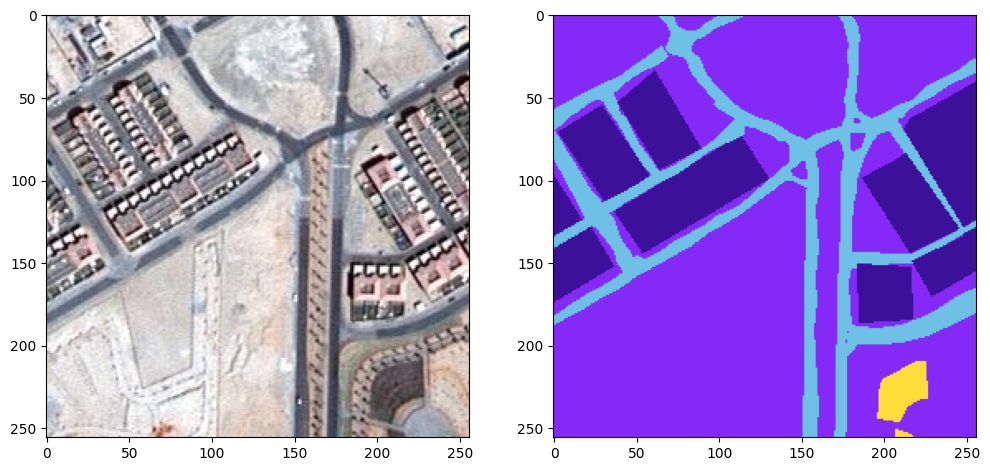

In [25]:
image_number = random.randint(0,len(image_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

OneHotEncoding

In [26]:
"""ohe = OneHotEncoder(sparse_output=False)
encoded_labels = ohe.fit_transform(labels.flatten().reshape(-1,1))
encoded_labels = encoded_labels.reshape((1305,256,256,6))
encoded_labels.shape"""

'ohe = OneHotEncoder(sparse_output=False)\nencoded_labels = ohe.fit_transform(labels.flatten().reshape(-1,1))\nencoded_labels = encoded_labels.reshape((1305,256,256,6))\nencoded_labels.shape'

In [356]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

torch.manual_seed(42)
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(image_dir)
        self.maskes = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.maskes[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")
        
        image = np.array(image)
        mask = np.array(mask)

        label = rgb_to_2D_label(mask)

        image = np.transpose(image,(2,0,1))
        label = np.transpose(label,(2,0,1))


        image = torch.from_numpy(image)
        label = torch.from_numpy(label)

        return image, label
    

BATCH_SIZE = 2
# Dataset ve DataLoader oluşturma
image_dir = 'ImageDataset'
mask_dir = 'MaskDataset'
dataset = SegmentationDataset(image_dir, mask_dir)
train_size = int(0.6*len(dataset))
test_val_size  = len(dataset) - train_size

train_dataset, test_val_set = torch.utils.data.random_split(dataset, [train_size, test_val_size])
test_dataset, val_dataset = torch.utils.data.random_split(test_val_set,[0.5,0.5])
print("Length of \nTrain:",len(train_dataset),"Test:",len(test_dataset),"Valid:",len(val_dataset))

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle = True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)
# Dataloader kullanarak veri yükleme
#for images, masks in dataloader:
#    print(images.shape, masks.shape)


Length of 
Train: 783 Test: 261 Valid: 261


In [357]:
len(train_loader)

392

In [358]:
num_batches = 16
for batch_idx, (img, mask) in enumerate(train_loader):
    pass
print(batch_idx,img.shape,mask.shape)

391 torch.Size([1, 3, 256, 256]) torch.Size([1, 6, 256, 256])


In [227]:
"""import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

torch.manual_seed(42)
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.maskes = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.maskes[idx])
        image = Image.open(img_path).convert("RGB")
        mask = np.load(mask_dir)
        print(mask)
        image = np.array(image)
        #label = rgb_to_2D_label(mask)

        image = np.transpose(image,(2,0,1))
        mask = np.transpose(mask,(2,0,1))

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        return image, mask

# Dönüşümler
transform = transforms.Compose([
    transforms.ToTensor()
])

BATCH_SIZE = 8
# Dataset ve DataLoader oluşturma
image_dir = 'ImageDataset'
mask_dir = 'ProcessedMaskDataset'
dataset = SegmentationDataset(image_dir, mask_dir, transform=transform)
train_size = int(0.6*len(dataset))
test_val_size  = len(dataset) - train_size

train_dataset, test_val_set = torch.utils.data.random_split(dataset, [train_size, test_val_size])
test_dataset, val_dataset = torch.utils.data.random_split(test_val_set,[0.5,0.5])
print("Length of \nTrain:",len(train_dataset),"Test:",len(test_dataset),"Valid:",len(val_dataset))

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle = True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)
# Dataloader kullanarak veri yükleme
#for images, masks in dataloader:
#    print(images.shape, masks.shape)
"""

'import os\nimport torch\nfrom torch.utils.data import Dataset, DataLoader\nfrom torchvision import transforms\nfrom PIL import Image\n\ntorch.manual_seed(42)\nclass SegmentationDataset(Dataset):\n    def __init__(self, image_dir, mask_dir, transform=None):\n        self.image_dir = image_dir\n        self.mask_dir = mask_dir\n        self.transform = transform\n        self.images = os.listdir(image_dir)\n        self.maskes = os.listdir(mask_dir)\n\n    def __len__(self):\n        return len(self.images)\n\n    def __getitem__(self, idx):\n        img_path = os.path.join(self.image_dir, self.images[idx])\n        mask_path = os.path.join(self.mask_dir, self.maskes[idx])\n        image = Image.open(img_path).convert("RGB")\n        mask = np.load(mask_dir)\n        print(mask)\n        image = np.array(image)\n        #label = rgb_to_2D_label(mask)\n\n        image = np.transpose(image,(2,0,1))\n        mask = np.transpose(mask,(2,0,1))\n\n        image = torch.from_numpy(image)\n    

In [208]:
temp_image = train_dataset.dataset.__getitem__(0)[0]
temp_mask = train_dataset.dataset.__getitem__(0)[1]
temp_image.shape,temp_mask.shape

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

In [ ]:
temp_image = temp_image.permute(1,2,0)


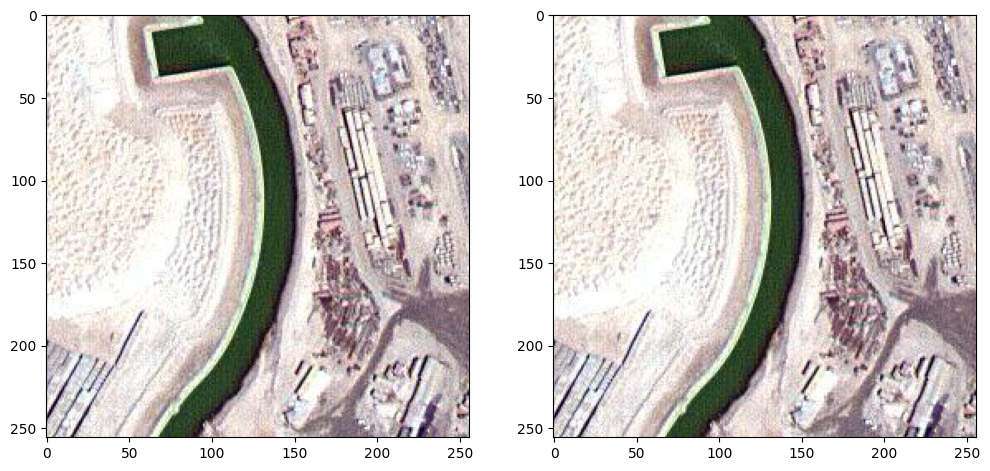

In [170]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(temp_image)
plt.subplot(122)
plt.imshow(np.reshape(temp_image, (patch_size, patch_size, 3)))
plt.show()

## Defining Model

In [30]:
import torch.nn as nn
import torch
import torchvision


class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), 
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UNet, self).__init__()
        self.conv1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2) 
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)

        self.conv10 = nn.Conv2d(64, out_ch, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)  
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)

        out = self.sigmoid(c10)
        return out

In [31]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    assert preds.shape == x.shape

if __name__ == "__main__":
    test()

In [32]:
test()

In [292]:
#class CNNmodel(nn.Module):
unet_model = UNET(in_channels=3,out_channels=6)
model = UNet(3,6)

### Loss And Optim

In [367]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define Cross-Entropy Loss
loss_fn = nn.CrossEntropyLoss()

# Define Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [372]:
def train(model, loader, loss_fn, optimizer):
    epoch_loss = 0.0
    times = 0
    model.train()
    print("__Train__")
    num_batches = 30
    
    for batch_idx,(x, y) in tqdm(enumerate(loader)):
        if batch_idx>=num_batches:
            break
        x = x.to(dtype=torch.float32)
        y = y.to(dtype=torch.float32)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(epoch_loss)
        times = times+1
    return epoch_loss / times

In [369]:
def validate(model,loader,loss_fn):
    epoch_loss = 0.0
    model.eval()
    times = 0
    num_batches = 30
    with torch.no_grad():
        for batch_idx, (x,y) in enumerate(loader):
            if batch_idx>=num_batches:
                break
            optimizer.zero_grad()
            x =x.to(dtype = torch.float32)
            y = y.to(dtype = torch.float32)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss +=loss.item()
            times = times+1
    return epoch_loss/times

In [370]:
i =0
epoch_loss = 0.0
for x,y in train_loader:
    i = i+1

print(f"i : {i} \nLength of Train Loader :{len(train_loader)}")

i : 392 
Length of Train Loader :392


In [365]:
len(train_loader)

392

In [373]:

from IPython.display import clear_output
train_losses = []
cross_losses = []
bestScore=float('inf')
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train(model,train_loader,loss_fn,optimizer)
    Current_loss = validate(model,val_loader,loss_fn)
    #print(Current_loss)
    #print(CurrentScore)
    train_losses.append(train_loss)
    cross_losses.append(Current_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')
    print(f'Cross Acc: {Current_loss:.4f}')
    #scheduler.step()

    # initialize 3 subplots to plot the loss curve, learning rate curve and accuracy curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(cross_losses, label='Validation Loss')
    plt.title('Training Loss and Validation Loss')
    plt.legend()
    plt.show(block=False)
    
    """
    if Current_loss < bestScore:
        bestScore = Current_loss
        best_epoch = epoch
        torch.save(unet_model.state_dict(), checkpoints_path)
    """
    

__Train__


1it [00:02,  2.71s/it]

1.442559003829956


2it [00:05,  2.71s/it]

2.981069564819336


3it [00:08,  2.75s/it]

4.441796541213989


4it [00:10,  2.72s/it]

5.659740209579468


5it [00:13,  2.70s/it]

7.024231314659119


6it [00:16,  2.72s/it]

8.26895296573639


7it [00:19,  2.72s/it]

9.587303042411804


8it [00:21,  2.71s/it]

10.901198267936707


9it [00:24,  2.71s/it]

12.221964001655579


10it [00:27,  2.75s/it]

13.555676102638245


11it [00:29,  2.73s/it]

15.149499535560608


12it [00:32,  2.73s/it]

16.444711327552795


13it [00:35,  2.73s/it]

17.830202221870422


14it [00:38,  2.73s/it]

19.092833518981934


KeyboardInterrupt: 

    import torch
    import torch.nn.functional as F

    def dice_loss(pred, target, smooth=1.0):
        pred = F.softmax(pred, dim=1)
        intersection = (pred * target).sum(dim=[2, 3])
        union = pred.sum(dim=[2, 3]) + target.sum(dim=[2, 3])
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()

    def combined_loss(pred, target, alpha=0.5, smooth=1.0):
        ce_loss = nn.CrossEntropyLoss()(pred, target)
        dice = dice_loss(pred, target, smooth)
        return alpha * ce_loss + (1 - alpha) * dice

In [51]:
for batch_idx, (img, mask) in enumerate(train_loader):
    continue
print(batch_idx,img.shape,mask.shape)

782 torch.Size([1, 3, 256, 256]) torch.Size([1, 256, 256, 6])
